## 0. Required dependencies ##
You'll need recent versions of jupyter (but if you're reading this, you are probably OK), opencv-python (and probably opencv-contrib-python), tqdm, scikit-learn, numpy, pandas and matplotlib. I've included a requirements.txt file for your convenience, but I basically use the most recent versions of everything, and the code works.

I advise you to use a form of virtual environments to manage your python projects (e.g. pipenv, venv, conda etc.).

To get free GPU time, you can try Google Colab. It is a tool for running notebooks, and provides you with a VM and a GPU for free! Most of the recent packages used in ML are automatically installed, so that is also nice.

In [1]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook
%matplotlib notebook

In [2]:
# filepath constants, set these according to your workflow:

# where are your datasets:
dataset_path = '../images/'
# where do you want to save your features and other outputs:
output_path = './'

In [3]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

## 1. Loading the data and the labels
First, let's get the training labels. The train data is ordered in a way such that all images in a class are stored in a separate folder, thus we can simply get a string represenation of the labels by using the folder names.

In [4]:
folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

print("Amount of classes: ", num_classes)
print("\nLabels: \n", label_strings)

Amount of classes:  12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [5]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

Let's take a look at a few examples of each class. We start by loading and displaying the first image of the 'tiger' class. Images loaded using OpenCV can be displayed using pyplot. One has to mind conventions: while using OpenCV, image channels are stored in the order blue-green-red, but pyplot assumes images to be stored in the more common RGB format. Luckily OpenCV's <code>cvtColor</code> method enables straight-forward conversion between the formats:

<IPython.core.display.Javascript object>


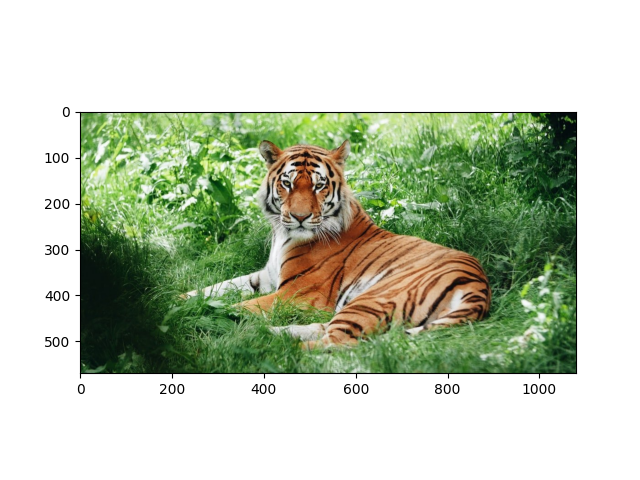

In [6]:
# load first image of class bobcat using opencv:
image = cv2.imread(train_paths['tiger'][0])

# images can be plotted using matplotlib, but need to be converted from BGR to RGB
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

Alright, let's see if we can learn more about how the different color channels are aligned in a numpy array which holds the image data. We'll plot each color channel individually:

Image shape: (570, 1080, 3)


<IPython.core.display.Javascript object>


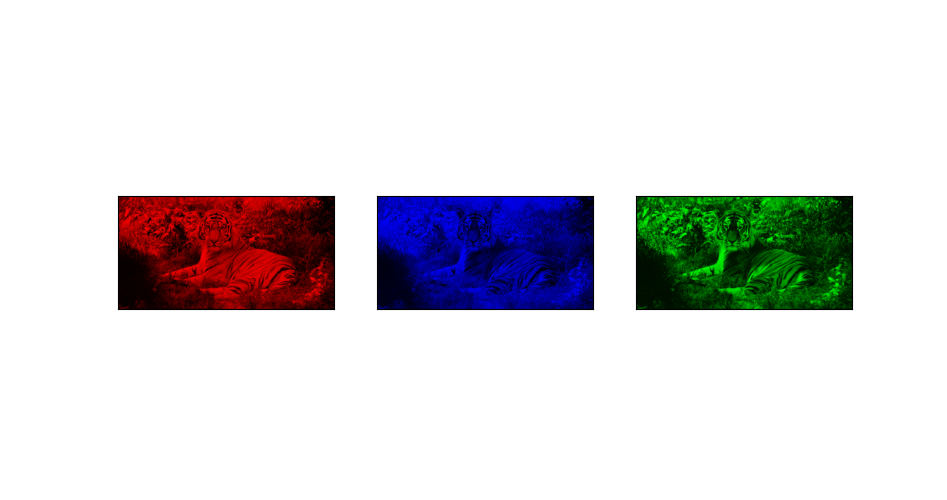

In [7]:
# blue, green and red channels are aligned along the third dimension of the returned numpy array
print('Image shape: {}'.format(image.shape))


# compute aspect ratio of image 
(height, width, nr_channels) = image.shape

aspect_ratio = width / float(height)

fig_height = 5

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(fig_height * aspect_ratio, fig_height))
[ax.get_xaxis().set_visible(False) for ax in axes]
[ax.get_yaxis().set_visible(False) for ax in axes]
ax0, ax1, ax2 = axes

# extract blue, green and red channels from image
blue_channel = image[:, :, 0]
green_channel = image[:, :, 1]
red_channel = image[:, :, 2]

ax0.imshow(np.dstack([red_channel, np.zeros_like(blue_channel), np.zeros_like(blue_channel)]))
ax1.imshow(np.dstack([np.zeros_like(green_channel), np.zeros_like(green_channel), green_channel]))
ax2.imshow(np.dstack([np.zeros_like(red_channel), blue_channel, np.zeros_like(red_channel)]))

plt.show()

## 2. Looking at the data
As we are warmed up now, we plot the first 3 images of each class to get a first impression on what our data looks like.

<IPython.core.display.Javascript object>


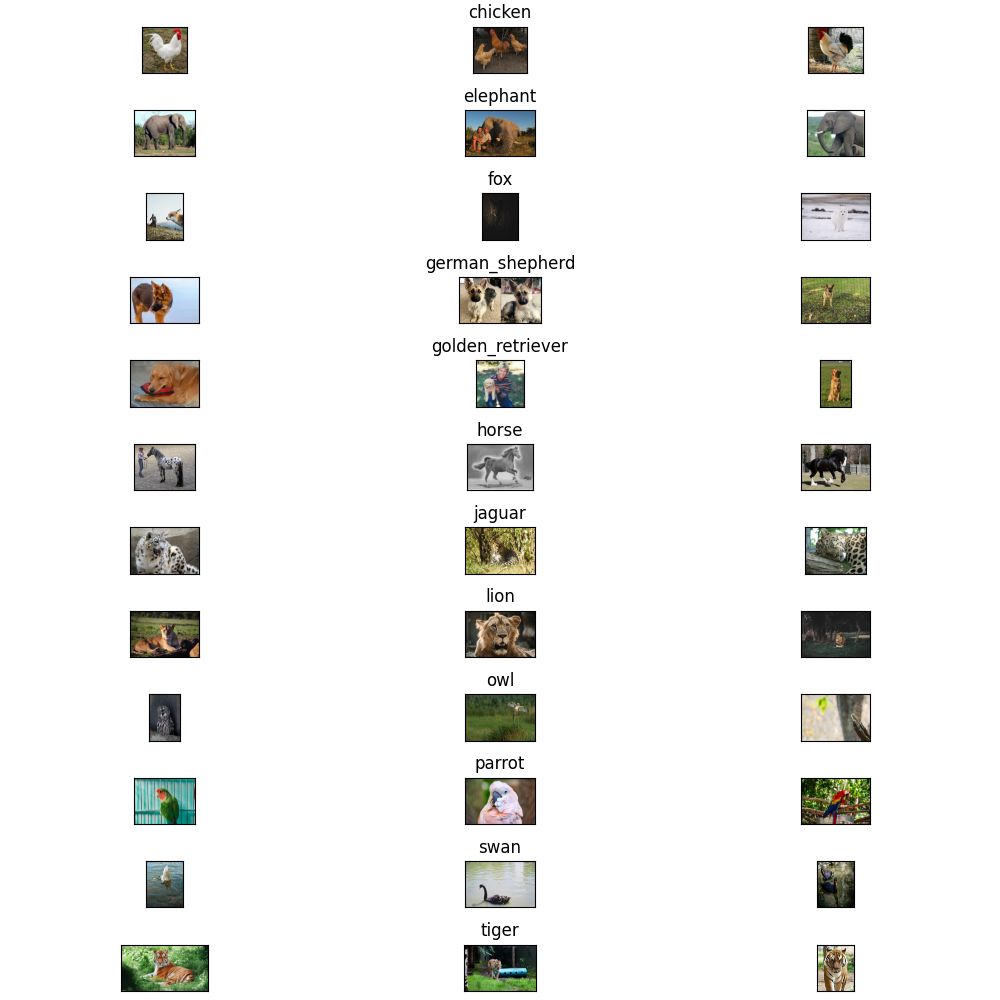

In [8]:
fig, axes = plt.subplots(nrows=num_classes, ncols=3, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:3]]

    for colidx in range(3):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 1: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

We can see that the images are quite diverse and vary in scale, viewpoint etc. This means that we will have to be careful to use the right feature descriptors in the feature extraction stage. We would prefer features which show a certain kind of invariance to this diversity. The dataset has been scraped from the web, which means that we can expect some degree of label noise as well.

## 2. The Bag-Of-Visual-Words model

The concept of a bag-of-words (BoW) model originates from the field of Natural Language Processing (NLP). In NLP problems, the input is text. However, for a machine learning model, we need numerical features as input. One way to translate text to features is to use part of its natural structure: the grouping of characters into words. To construct a BoW-model, you do the following (with possible fine-tunings for each step):

* Make a histogram of all the words in the text, throw out words that are not important (e.g., typos, words in another language, short words like 'the', 'an', 'of', ...) and possibly group similar words (e.g., conjugations of the same verb, synonyms ...).
* Keep the k most frequently occurring words (with k a hyperparameter).
* For each document, make a (k x 1) vector for which the i-th value corresponds to the number of times the i-th word occurs in that document.
* Additionally, or as an alternative, you can also make binary vectors (only recording whether or not a word occurs in a document, not how frequently).

This gives you long but sparse feature vectors that you can use in a machine learning model.

In a visual BoW, we do something similar for images. The problem is that there aren't any 'words' naturally available. Instead, we want to look for 'typical local structures' in the image (e.g. small significant areas or patches). Obviously, this shifts the problem to defining what 'typical patches' are. Luckily, there exist a range of feature extractors in image processing that detect those interesting patches. What this means exactly depends on the specific feature type, but these patches (or transformed representations of those) can be used to construct a dictionary for images. How this is done exactly is explained in more detail in the 'creating_vbow' notebook on this topic. It basically boils down to the following:

* We extract the chosen type of features for all the images in the training set (the maximal number is upper bounded by a hyperparameter).
* Accross this huge set of patches, we cluster similar patches together into a set number of classes (another hyperparameter, which sets the number of BoW features), and compute the 'average patch' for each cluster -- these are the visual 'words'.
* We then encode each image (from train set or test set) in a similar way to the BoW model: we assign each extracted patch to a cluster (word) and count how many times each cluster occurs in each image.

For the competition, the focus lies on correctly applying and implementing the standard machine learning flow. In order to get you started, we have implemented a simple version of this BoW procedure for you. As a first step, we advise you to simply use that and focus on everything else. If you want to aim for excellent scores, you can try improving this simple VBoW approach by tuning the extraction yourself. Note that this uses k-means clustering, a very commmon unsupervised technique for clustering. You can find a lot of information on this technique on the web.

In what follows, we only show you how to use the code provided by us. For the details of the code itself, we refer to the second notebook and the code in the 'features' file.

## 3. Using the provided image features

Download the feature files provided on the Kaggle competition site. These contain raw image features before the creation of clusters and the counting of the visual words. You can also re-extract them yourself using the code in the 'creating_vbow' notebook, or extract other kinds of features there.

In what follows, we simply load the extracted features from disk. They are stored as pickle files, which are just files serialized for python.

In this case, we'll use the freak features provided to you. But definitely read the creating_vbow notebook and take a look at the other features, it could inspire you to try new things.

In [9]:
descriptor_desired = 'freak'

In [10]:
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))

Number of encoded train images: 4042


In [11]:
with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))

Number of encoded test images: 4035


The next thing we need to do is to cluster the training features into the words that will construct our dictionary. You are NOT allowed to use features from the test images to do this. Even if you did use the test images, it would not improve your final performance, since you are overfitting your model on the test set, which is an error you have to avoid at all times. In addition, when using validation or cross-validation, the validation set should also not be used here. Think about your clustering and your train/test/validations splits, and how you will avoid information leakage here...

Note that the number of categories (words) is a hyperparameter that should be optimised, ideally with grid search, but you can also try it manually. For this starting example, we give it a try with <code>codebook_size=500</code>. 

The functions we use below are implemented in the 'helpers' library. Our kind thanks go out to the authors of [https://github.com/flytxtds/scene-recognition](https://github.com/flytxtds/scene-recognition), from where this code has been adapted. 

The code below creates the desired encoded BoW feature vector.

**Important note:** if you were to encounter an error, similar to 'ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index X has 0 dimension(s)', or: 'ValueError: Expected 2D array, got scalar array instead: array=nan.', this is because your feature descriptor has found no patches on a certain image. If this is in your training set, you can simply remove this image and recreate your features. You can find the image for the former error by printing

    train_features_from_pkl[X] 

(with X the index from your error message), or for the latter error with

    for i, img in enumerate(train_features_from_pkl):
        try:
            _ = len(img.data)
        except ValueError as e:
            print(img)

Let me know what image it was, and I'll update the dataset on Kaggle for the others. It is especially important to let me know if this error occurred in the test set, since otherwise you won't be able to submit a good submission. You can send an e-mail to andries.rosseau@vub.be.

In [12]:
# learn the codebook for the 'freak' features from the training data

codebook_size = 500

clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)

training took 18.75065016746521 seconds


In [13]:
# encode all train images 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)

In [14]:
# encode all test images 
test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)

Now that we have readily useable train and test data matrices, there is only one thing missing: our label vector still contains string representations of our labels, but in order to train a supervised classifier, we need the labels to be represented as integers of course. The <code>LabelEncoder</code> class of sklearn does exactly that.

In [15]:
# use a labelencoder to obtain numerical labels
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
print(train_labels[:10])
train_labels = label_encoder.transform(train_labels)
print(train_labels[:10])

['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]


We now have feature vectors with hopefully meaningful BOVW representations, as well as a train label vector in the right format. We are all set to start and train a supervised model on our data, do feature selection, model evaluation etc. This is where you come in, of course. As a last step, we will show how to generate a sample submission for the competition homepage using a 'prior probability algorithm', which simply outputs the prior probabilities of the classes.

## 4. Making a submission
For our naive sample submission we just count the amount of training samples per class, and divide them by the total amount of samples to get our output probabilities for every test sample. <code>helpers.writePredictionsToCsv</code> can be used to write out predictions as a csv file ready to be submitted to the competition page.

In [16]:
# Compute a naive prediction
prior_predictions = np.array([len(train_paths[label]) for label in label_strings])
prior_predictions = prior_predictions / np.sum(prior_predictions)
print(prior_predictions)

prior_predictions = np.tile(prior_predictions, (len(test_paths), 1))

# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('prior_probas', 'csv'))
helpers.writePredictionsToCsv(prior_predictions, pred_file_path, label_strings)

[0.13607125 0.10761999 0.06160317 0.11429985 0.01855517 0.11528946
 0.021524   0.0974765  0.07941613 0.10044532 0.05294409 0.09475507]


Submitting the csv file generated should give you a public leaderboard score of about 2.36. It's up to you now to build a classifier that at least beats these prior scores (and then keep improving of course). Good luck competing!